Problem Statement: To classify manipulated images from real ones

Data: Source-https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images The dataset is in the form of images.

Type of Machine Learning Problem: Classifying data into real and fake=> Binary Classification

Performance Metric: Metrics: Confusion matrix, Accuracy, Precision, Recall, F1 Score, roc curve and auc

Machine Learning Objective: Developing a model which is used to classify manipulated images from original ones

In [83]:
import numpy as np
import tensorflow as tf
from PIL import Image
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import load_img,img_to_array
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from joblib import dump, load
from sklearn import tree
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import display
import cv2 as cv
import seaborn as sns
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

Creating a dataframe for all the image files

In [84]:
fake_folder = 'C:\projects_sree\dataset\Test\Fake'
real_folder = 'C:\projects_sree\dataset\Test\Real'

fake_df = pd.DataFrame({'image_path': [os.path.join(fake_folder, img) for img in os.listdir(fake_folder)],
                        'label': 0})  # Label 0 for fake images
real_df = pd.DataFrame({'image_path': [os.path.join(real_folder, img) for img in os.listdir(real_folder)],
                        'label': 1})  # Label 1 for real images

combined_df = pd.concat([fake_df, real_df], ignore_index=True)

In [85]:
combined_df.head()

,image_path,label
0,C:\projects_sree\dataset\Test\Fake\fake_0.jpg,0
1,C:\projects_sree\dataset\Test\Fake\fake_1.jpg,0
2,C:\projects_sree\dataset\Test\Fake\fake_10.jpg,0
3,C:\projects_sree\dataset\Test\Fake\fake_100.jpg,0
4,C:\projects_sree\dataset\Test\Fake\fake_1000.jpg,0


Some of the images from the dataset

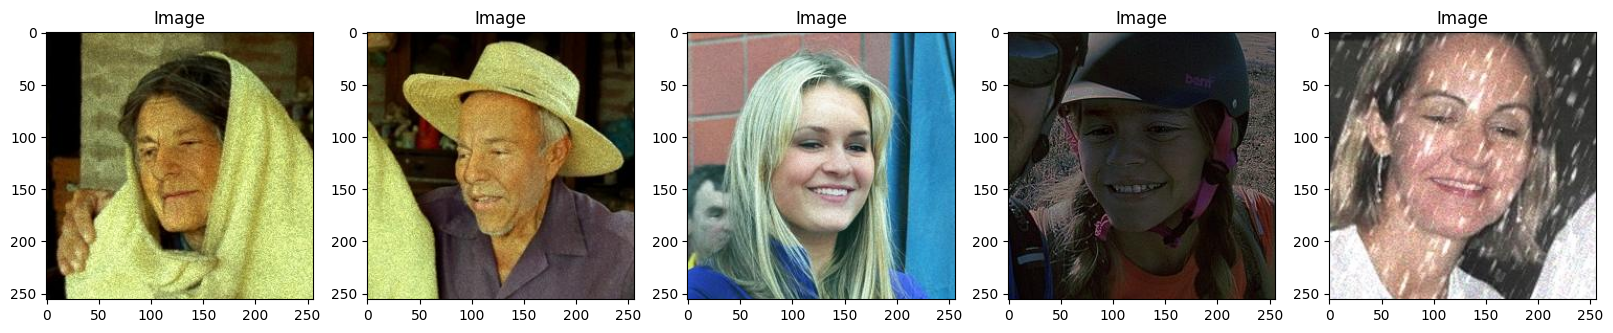

In [86]:
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i in range(5):
    img = Image.open(combined_df.image_path[i])
    axes[i].imshow(img)
    axes[i].set_title('Image')
plt.show()

Extracting features of the images using ResNet50 model

In [87]:
#Loading Resnet50 model with imagenet weights
model = ResNet50(weights = 'imagenet',include_top = False)

In [88]:
#Demonstration of Extracting features for the images
image_df = pd.DataFrame()
image_df = combined_df.iloc[:50].copy()
image_paths = image_df['image_path']
all_features = []
for img in image_paths:
    #preprocessing the image
    image = load_img(img,target_size=(224, 224))
    img_array = img_to_array(image)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array,axis=0)
    #predicting features
    features = model.predict(img_array)
    #storing features
    all_features.append(features)

1/1 [==============================] - 0s 100ms/step


Visualisation of some features of the image

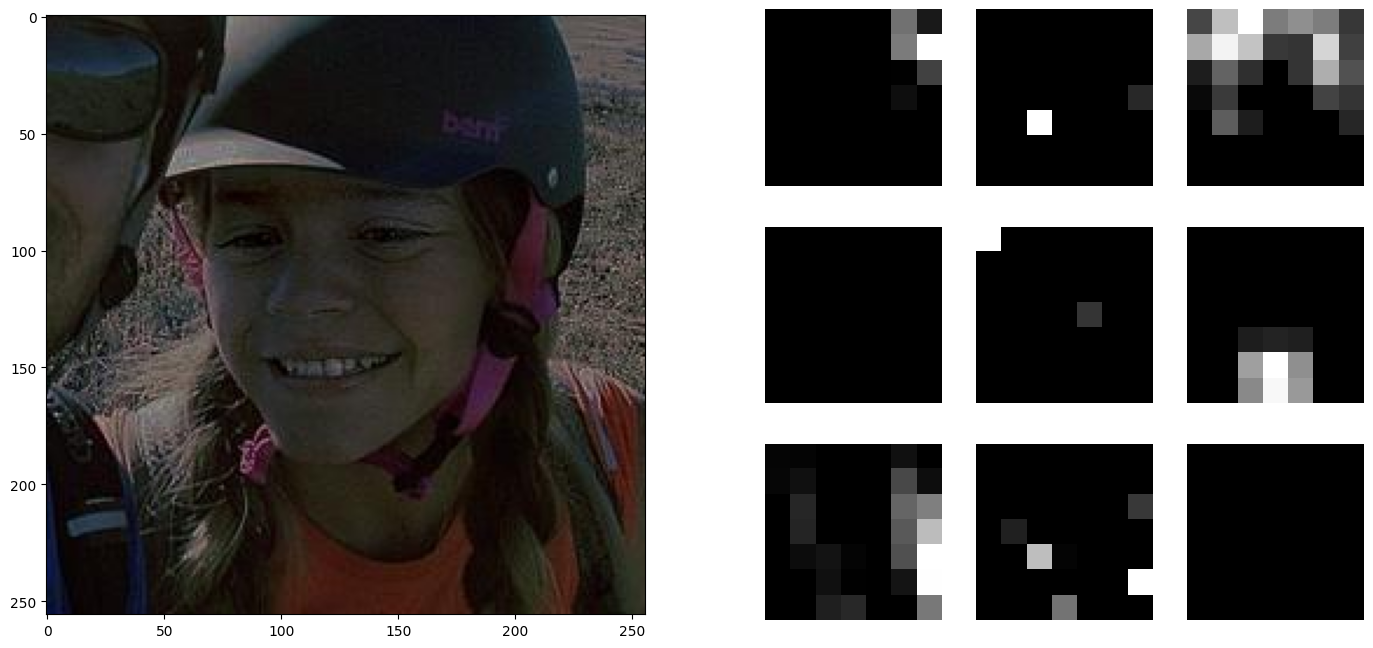

In [89]:
orig = combined_df.image_path[3]
orig = Image.open(orig)
n_features = all_features[3].shape[-1]

fig = plt.figure(figsize = (17, 8))
gs = gridspec.GridSpec(1,2,figure = fig)
sub_gs = gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec=gs[1])
ax1 = fig.add_subplot(gs[0])
ax1.imshow(orig)
for i in range(3):
    for j in range(3):
        ax2 = fig.add_subplot(sub_gs[i,j])
        plt.axis('off')
        plt.imshow(features[0,:,:,np.random.randint(n_features)],cmap='gray')

In [90]:
all_features[0].shape

(1, 7, 7, 2048)

Flattening all the features

In [91]:
all_flattened_features=[]
for i in all_features:
    flattened_array = i.reshape(-1)
    all_flattened_features.append(flattened_array)

In [92]:
all_flattened_features[0].shape

(100352,)

In [93]:
#combining of combined_df and all_flattened_features in df
df = combined_df[0:50].copy()
df['flattened_features'] = all_flattened_features
df.head()

,image_path,label,flattened_features
0,C:\projects_sree\dataset\Test\Fake\fake_0.jpg,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C:\projects_sree\dataset\Test\Fake\fake_1.jpg,0,"[0.0, 1.2874295, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,C:\projects_sree\dataset\Test\Fake\fake_10.jpg,0,"[0.0, 0.0, 0.0, 3.0799298, 0.0, 0.0, 2.3750925..."
3,C:\projects_sree\dataset\Test\Fake\fake_100.jpg,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,C:\projects_sree\dataset\Test\Fake\fake_1000.jpg,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [94]:
#actual dataset used for training (it has around 2000 images)
#loading dataset from pickle file
df = pd.read_pickle("actual_dataset.pkl")
df.head()

,image_path,label,flattened_features
0,C:\projects_sree\dataset\Test\Real\real_4335.jpg,1,"[0.0, 1.6351374, 0.0, 2.184649, 0.0, 0.0, 0.0,..."
1,C:\projects_sree\dataset\Test\Real\real_2178.jpg,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C:\projects_sree\dataset\Test\Real\real_5274.jpg,1,"[0.0, 0.23420814, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,C:\projects_sree\dataset\Test\Fake\fake_4973.jpg,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,C:\projects_sree\dataset\Test\Fake\fake_3664.jpg,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.87244546, 0.0..."


In [95]:
df.shape

(2000, 3)

In [96]:
#splitting data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
x_train = train_df['flattened_features']
x_train = x_train.tolist()
y_train = train_df['label']
x_test = test_df['flattened_features']
x_test = x_test.tolist()
y_test = test_df['label']

#training model
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(x_train,y_train)

#predicting test images 
y_pred = tree_model.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
pre = precision_score(y_test,y_pred)
re = recall_score(y_test,y_pred)

print("Accuracy:",acc)
print("F1 score:",f1)
print("Precision:",pre)
print("Recall:",re)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.69
F1 score: 0.6852791878172588
Precision: 0.7258064516129032
Recall: 0.6490384615384616
Confusion Matrix:
[[141  51]
 [ 73 135]]


In [97]:
#saving the model
dump(tree_model, f'decision_tree_model.joblib')

['decision_tree_model.joblib']

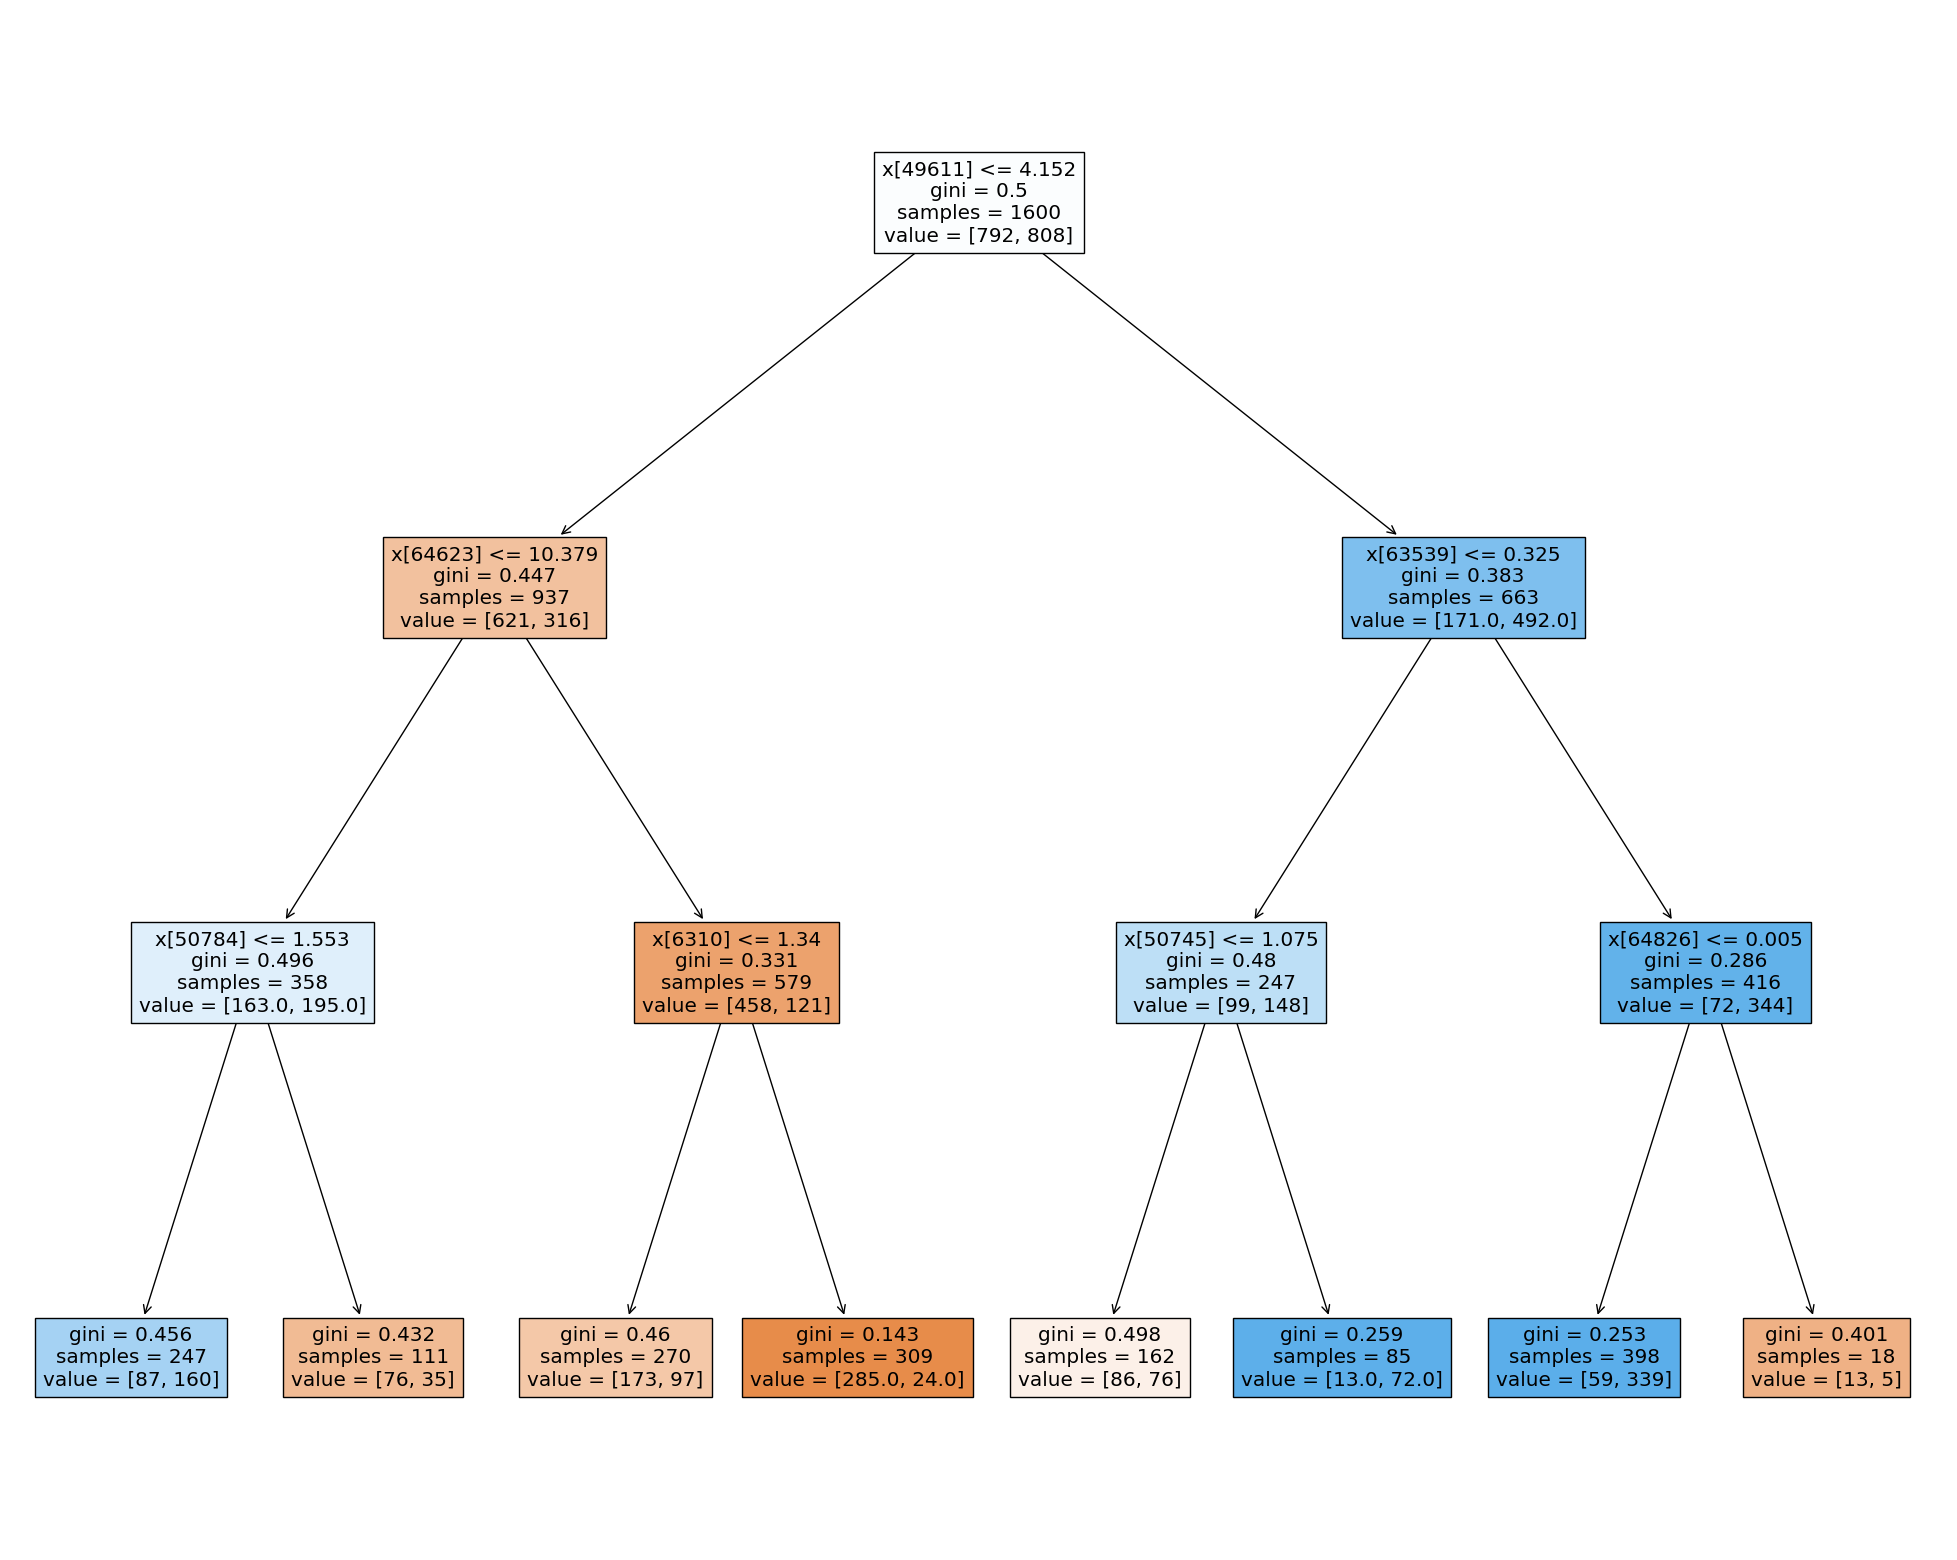

In [98]:
#visualisation of decision tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_model, filled=True)

In [99]:
#text representation of decision tree
text_representation = tree.export_text(tree_model)
print(text_representation)

|--- feature_49611 <= 4.15
|   |--- feature_64623 <= 10.38
|   |   |--- feature_50784 <= 1.55
|   |   |   |--- class: 1
|   |   |--- feature_50784 >  1.55
|   |   |   |--- class: 0
|   |--- feature_64623 >  10.38
|   |   |--- feature_6310 <= 1.34
|   |   |   |--- class: 0
|   |   |--- feature_6310 >  1.34
|   |   |   |--- class: 0
|--- feature_49611 >  4.15
|   |--- feature_63539 <= 0.32
|   |   |--- feature_50745 <= 1.07
|   |   |   |--- class: 0
|   |   |--- feature_50745 >  1.07
|   |   |   |--- class: 1
|   |--- feature_63539 >  0.32
|   |   |--- feature_64826 <= 0.01
|   |   |   |--- class: 1
|   |   |--- feature_64826 >  0.01
|   |   |   |--- class: 0



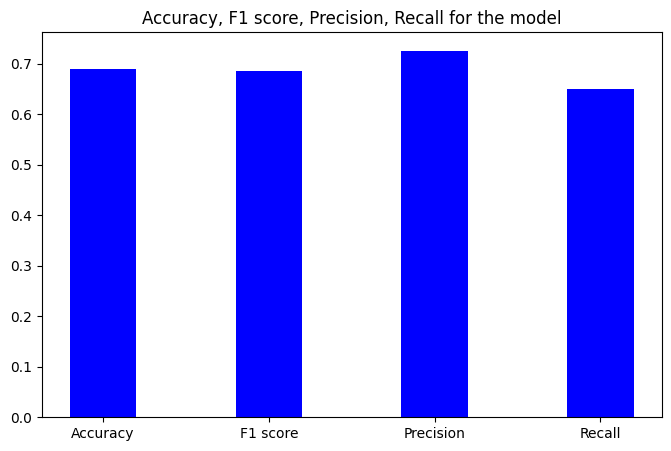

In [100]:
#bar plot of accuracy, f1_score, precision, recall of the tree model
scores = [acc,f1,pre,re]
names = ['Accuracy','F1 score','Precision','Recall']
fig = plt.figure(figsize = (8, 5))
plt.bar(names, scores, color='blue', width=0.4)
plt.title("Accuracy, F1 score, Precision, Recall for the model")
plt.show()

<Axes: >

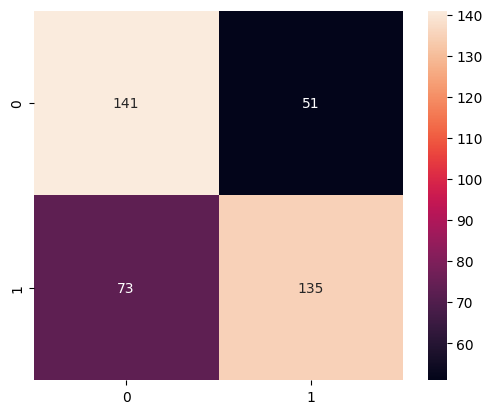

In [101]:
#confusion matrix heatmap
sns.heatmap(cm, square = True, fmt = 'd', xticklabels = 1, yticklabels = 1, annot = True)

classifying using Logistic Regression

In [102]:
#splitting data
train,test = train_test_split(df,test_size=0.2,random_state=42)
x_train = train['flattened_features']
x_train = x_train.tolist();
y_train = train['label']
x_test = test['flattened_features']
x_test = x_test.tolist()
y_test = test['label']

#training logistic model
logistic_model = LogisticRegression(random_state=0)
logistic_model.fit(x_train,y_train)

#predicting test images 
y_pred = logistic_model.predict(x_test)
acc_log = accuracy_score(y_test,y_pred)
cm_log = confusion_matrix(y_test,y_pred)
pre_log = precision_score(y_test,y_pred)
re_log = recall_score(y_test,y_pred)

print("Accuracy:",acc_log)
print("Precision:",pre_log)
print("Recall:",re_log)
print("Confusion Matrix:")
print(cm_log)

Accuracy: 0.8125
Precision: 0.8151658767772512
Recall: 0.8269230769230769
Confusion Matrix:
[[153  39]
 [ 36 172]]


ROC curve and AUC (area under curve)

In [103]:
#saving the model
dump(logistic_model, f'logistic_model_deepfake.joblib')

['logistic_model_deepfake.joblib']

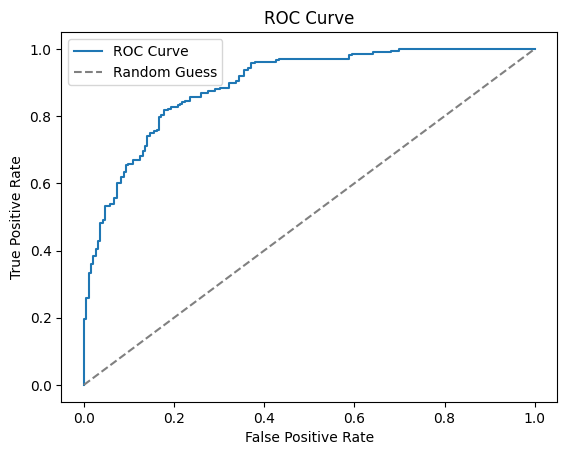

AUC: 0.8935046073717948


In [104]:
# Get predicted probabilities for the positive class
y_pred_proba = logistic_model.predict_proba(x_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

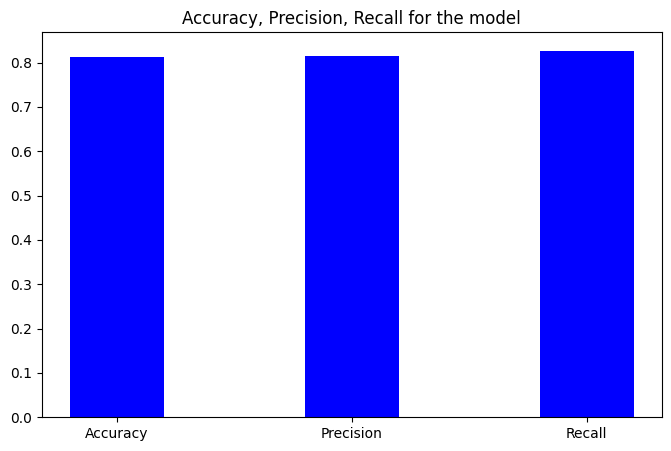

In [105]:
#bar plot of accuracy, f1_score, precision, recall of the tree model
scores = [acc_log,pre_log,re_log]
names = ['Accuracy','Precision','Recall']
fig = plt.figure(figsize = (8, 5))
plt.bar(names, scores, color='blue', width=0.4)
plt.title("Accuracy, Precision, Recall for the model")
plt.show()

<Axes: >

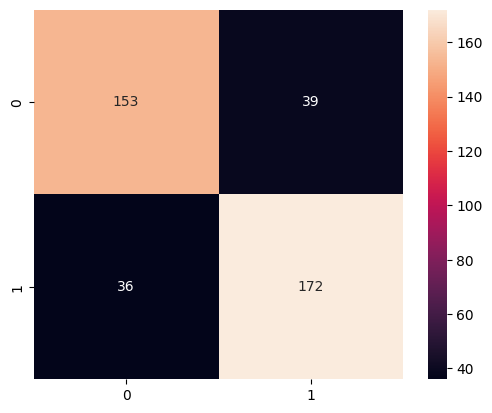

In [106]:
sns.heatmap(cm_log, square = True, fmt = 'd', xticklabels = 1, yticklabels = 1, annot = True)